In [1]:
import re
from typing import Dict, Iterable, List

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
# import plotly
import pymorphy2
from IPython.display import display
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate
from tqdm import tqdm_notebook

plt.style.use("ggplot")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sofi_flin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sofi_flin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
SEED = 42
np.random.seed(SEED)

### **Загрузка данных из разных датасетов и выбор из них нужных столбцов с последующей их конкатенацией. Далее следует объединение датосетов в один**

In [166]:
df1 = pd.read_csv('kinopoisk-top250.csv')

df1.head()

,rating,movie,year,country,rating_ball,overview,director,screenwriter,actors,url_logo
0,0,Побег из Шоушенка,1994,США,9.111,Бухгалтер Энди Дюфрейн обвинён в убийстве собс...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Тим Роббинс; Морган Фриман; Боб Гантон; Уильям...,'https://st.kp.yandex.net/images/film_iphone/i...
1,1,Зеленая миля,1999,США,9.062,Пол Эджкомб — начальник блока смертников в тюр...,Фрэнк Дарабонт,Фрэнк Дарабонт; Стивен Кинг,Том Хэнкс; Дэвид Морс; Бонни Хант; Майкл Кларк...,'https://st.kp.yandex.net/images/film_iphone/i...
2,2,Форрест Гамп,1994,США,8.913,От лица главного героя Форреста Гампа; слабоум...,Роберт Земекис,Эрик Рот; Уинстон Грум,Том Хэнкс; Робин Райт; Салли Филд; Гэри Синиз;...,'https://st.kp.yandex.net/images/film_iphone/i...
3,3,Список Шиндлера,1993,США,8.817,Фильм рассказывает реальную историю загадочног...,Стивен Спилберг,Стивен Зеллиан; Томас Кенилли,Лиам Нисон; Бен Кингсли; Рэйф Файнс; Кэролайн ...,'https://st.kp.yandex.net/images/film_iphone/i...
4,4,1+1,2011,Франция,8.807,Пострадав в результате несчастного случая; бог...,Оливье Накаш; Эрик Толедано,Оливье Накаш; Филипп Поццо ди Борго; Эрик Т...,Франсуа Клюзе; Омар Си; Анн Ле Ни; Одри Флеро;...,'https://st.kp.yandex.net/images/film_iphone/i...


In [167]:
df2 = pd.DataFrame()
df2['sentence'] = df1['movie']+df1['overview']

In [168]:
df2

,sentence
0,Побег из Шоушенка Бухгалтер Энди Дюфрейн обвин...
1,Зеленая миля Пол Эджкомб — начальник блока сме...
2,Форрест Гамп От лица главного героя Форреста Г...
3,Список Шиндлера Фильм рассказывает реальную ис...
4,1+1 Пострадав в результате несчастного случая;...
...,...
245,Крамер против Крамера Тед Крамер; целиком посв...
246,Пираты Карибского моря: На краю Света Новые пр...
247,Иди и смотри Флера — шестнадцатилетний мальчиш...
248,Профессионал Убить президента африканской респ...


In [9]:
def remove_numbers_punctuation_and_hyphens(text):
    # Удаление чисел, знаков препинания и тире из строки
    cleaned_text = re.sub(r'[-\d.,?!:;()\'\"<>{}[\]\|/@#$%^&*_+=~`]', '', text)
    return cleaned_text

In [169]:
df3 = pd.read_csv('extended_anime.csv')

df3.head()

,Unnamed: 0,Title,Short title,Href,Translation,Description,Count episodes,Genres,Rating,Rating count,...,Character designers,Characters,Seiyuu,Translators,Tags,Popularity,Reviews,Quotes,Similar anime,Image src
0,0,Ходячий замок (Howl's Moving Castle: Howl no U...,Ходячий замок,https://findanime.net/hodiachii_zamok,переведено,"«Ходячий замок» — полнометражное аниме, выпуще...",1.0,"['паропанк', 'фэнтези', 'сказка', 'приключения...",4.9,4.9,...,['Ямасита Акихико'],"['Софи Хаттер', 'Хаул']","['Байсё Тиэко', 'Кимура Такуя']",['ReaniMedia'],[],3.0,"['\xa0 \xa0 ""Ходячий замок Хаула"", в другой тр...","['Прости меня, я такая капуша: ты ждал меня вс...","['Навсикая из Долины Ветров', 'Унесённые призр...",https://static.findanime.net/uploads/pics/00/1...
1,1,Унесённые призраками (Spirited Away: Sen to Ch...,Унесённые призраками,https://findanime.net/unesennye_prizrakami,переведено,Вместе с родителями маленькая Тихиро переезжае...,1.0,"['приключения', 'мистика', 'драма', 'семейный'...",4.9,5.0,...,['Андо Масаси'],"['Тихиро Огино', 'Хаку (Унесённые призраками)']","['Тамай Юми', 'Хиираги Руми', 'Ирино Мию', 'Ка...",[],[],3.0,[' Лет 10-12 назад (уж и не помню точно) зашла...,"['Если забудешь своё имя, то не сможешь вернут...","['Ходячий замок', 'Мой сосед Тоторо', 'Тетрадь...",https://static.findanime.net/uploads/pics/00/1...
2,2,Стальной Алхимик: Братство [ТВ-2] (FullMetal A...,Стальной Алхимик: Братство [ТВ-2],https://findanime.net/stalnoi_alhimik__bratstv...,переведено,Нарушив главный запрет Алхимии и попытавшись в...,68.0,"['война', 'драма', 'комедия', 'паропанк', 'фэн...",4.9,4.9,...,['Канно Хироки'],[],"['Фудзивара Кэйдзи', 'Ёсино Хироюки (сэйю)', '...","['Ancord', 'MiraiDuB', 'AlFair Studio', 'AniDu...","['Холодное оружие', 'Империи', 'Дружба', 'Учит...",3.0,['\xa0 \xa0Тема сравнения двух версий сериала ...,['- Мне нравится эта вечная зима. Всё либо чер...,['Стальной Алхимик [ТВ-1]'],https://static.findanime.net/uploads/pics/00/1...
3,3,Волейбол! 2 (Haikyuu!! Second Season: Haikyu!!...,Волейбол! 2,https://findanime.net/voleibol__2__A5678,переведено,"После участия в межшкольном чемпионате, волейб...",25.0,"['комедия', 'сёнэн', 'драма', 'спорт', 'школа']",4.9,4.9,...,['Кисида Такахиро'],"['Кэйдзи Акаси', 'Хитока Яти', 'Кэндзи Футакут...","['Хосоя Ёсимаса', 'Морикубо Сётаро', 'Нака Хир...","['AniPlay.TV', 'AniStar', 'AniLibria.TV', 'AOS...","['Несколько ГГ', 'Дружба', 'Волейбол', 'Спорти...",3.0,['Вот и дошли руки написать отзыв о втором сез...,[],"['Баскетбол Куроко [ТВ-1]', 'Синяя тюрьма: Блю...",https://static.findanime.net/uploads/pics/00/4...
4,4,В лесу мерцания светлячков (Into the Forest of...,В лесу мерцания светлячков,https://findanime.net/into_the_forest_of_firef...,переведено,"Маленькая девочка заблудилась в лесу, но вдруг...",1.0,"['мистика', 'сёдзё', 'романтика', 'трагедия', ...",4.8,4.7,...,[],[],"['Утияма Коки', 'Сакура Аянэ']","['LE-Production', 'AniWave', 'Akari GROUP', 'A...",[],3.0,"['""И максимальной оценки будет мало...""Могу че...",[],"['Тетрадь дружбы Нацумэ', 'Сад изящных слов', ...",https://static.findanime.net/uploads/pics/00/1...


In [170]:
df4 = pd.DataFrame()
df4['sentence'] = df3['Short title'] + ' ' +df3['Description']
df4

,sentence
0,Ходячий замок «Ходячий замок» — полнометражное...
1,Унесённые призраками Вместе с родителями мален...
2,Стальной Алхимик: Братство [ТВ-2] Нарушив глав...
3,Волейбол! 2 После участия в межшкольном чемпио...
4,В лесу мерцания светлячков Маленькая девочка з...
...,...
7769,NaN
7770,Сентиментальное путешествие Сентиментальное пу...
7771,Ветролом Харука Сакура не хочет иметь ничего о...
7772,Непобедимый властелин История Ван Кэ – совреме...


In [14]:
df22 = pd.DataFrame()
df22['sentence'] = df2['sentence'].apply(remove_numbers_punctuation_and_hyphens)

In [16]:
def pd_remove_numbers_punctuation_and_hyphens(text):
    # Удаление чисел, знаков препинания и тире из строки
    cleaned_text = re.sub(r'[-\d.,?!:;()\'\"<>{}[\]\|/@#$%^&*_+=~`]', '', str(text))
    return cleaned_text

# Применение функции к столбцу 'sentence' DataFrame
df44 = pd.DataFrame()
df44['sentence'] = df4['sentence'].apply(pd_remove_numbers_punctuation_and_hyphens)

# Замена всех символов '\xa0' на пробел
df44['sentence'] = df44['sentence'].str.replace('\xa0', ' ')

In [17]:
df44

,sentence
0,Ходячий замок «Ходячий замок» — полнометражное...
1,Унесённые призраками Вместе с родителями мален...
2,Стальной Алхимик Братство ТВ Нарушив главный з...
3,Волейбол После участия в межшкольном чемпиона...
4,В лесу мерцания светлячков Маленькая девочка з...
...,...
7769,nan
7770,Сентиментальное путешествие Сентиментальное пу...
7771,Ветролом Харука Сакура не хочет иметь ничего о...
7772,Непобедимый властелин История Ван Кэ – совреме...


In [18]:
df44 = df44.dropna(subset=['sentence'])
df44

,sentence
0,Ходячий замок «Ходячий замок» — полнометражное...
1,Унесённые призраками Вместе с родителями мален...
2,Стальной Алхимик Братство ТВ Нарушив главный з...
3,Волейбол После участия в межшкольном чемпиона...
4,В лесу мерцания светлячков Маленькая девочка з...
...,...
7769,nan
7770,Сентиментальное путешествие Сентиментальное пу...
7771,Ветролом Харука Сакура не хочет иметь ничего о...
7772,Непобедимый властелин История Ван Кэ – совреме...


In [19]:
df44 = df44.drop(df44[df44['sentence'].str.contains('nan', na=False)].index)
df44

,sentence
0,Ходячий замок «Ходячий замок» — полнометражное...
1,Унесённые призраками Вместе с родителями мален...
2,Стальной Алхимик Братство ТВ Нарушив главный з...
3,Волейбол После участия в межшкольном чемпиона...
4,В лесу мерцания светлячков Маленькая девочка з...
...,...
7768,Идолмастер Девушкизолушки — U Сюжет рассказыва...
7770,Сентиментальное путешествие Сентиментальное пу...
7771,Ветролом Харука Сакура не хочет иметь ничего о...
7772,Непобедимый властелин История Ван Кэ – совреме...


In [21]:
import glob

In [22]:
txt_movie_files = glob.glob("marus_data/dataset/neg/*.txt")
txt_movie_files = txt_movie_files + glob.glob("marus_data/dataset/neu/*.txt")
txt_movie_files = txt_movie_files + glob.glob("marus_data/dataset/pos/*.txt")

In [23]:
#txt_add_files = glob.glob("marus_data/prose/Blok/*.txt")

In [24]:
#txt_add_files

In [25]:
#txt_add_files = txt_add_files + glob.glob("RusLit/poems/Lermontov/*.txt")

In [26]:
#txt_add_files = txt_add_files + glob.glob("RusLit/poems/Nekrasov/*.txt")
#txt_add_files = txt_add_files + glob.glob("RusLit/poems/Pushkin/*.txt")
#txt_add_files = txt_add_files + glob.glob("RusLit/prose/Blok/*.txt")
'''txt_add_files = txt_add_files + glob.glob("marus_data/prose/Bryusov/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Chekhov/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Dostoevsky/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Gogol/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Gorky/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Dostoevsky/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Herzen/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Lermontov/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Pushkin/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Tolstoy/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/prose/Turgenev/*.txt")
txt_add_files = txt_add_files + glob.glob("marus_data/ublicism/Tolstoy/*.txt")'''

'txt_add_files = txt_add_files + glob.glob("marus_data/prose/Bryusov/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Chekhov/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Dostoevsky/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Gogol/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Gorky/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Dostoevsky/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Herzen/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Lermontov/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Pushkin/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Tolstoy/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/prose/Turgenev/*.txt")\ntxt_add_files = txt_add_files + glob.glob("marus_data/ublicism/Tolstoy/*.txt")'

In [27]:
#txt_files

In [28]:
'''def split_sentences(text):
    sentences = re.split(r'[.!?]+|\n', text)
    # Удаление чисел
    text = re.sub(r'\d+', '', text)
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)
    # Удаляем пустые строки и лишние пробелы
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences
    '''

"def split_sentences(text):\n    sentences = re.split(r'[.!?]+|\n', text)\n    # Удаление чисел\n    text = re.sub(r'\\d+', '', text)\n    # Удаление знаков препинания\n    text = re.sub(r'[^\\w\\s]', '', text)\n    # Удаляем пустые строки и лишние пробелы\n    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]\n    return sentences\n    "

In [29]:
def split_sentences(text):
    # Разбиение текста на предложения по символам ".", "!", "?", или "\n"
    sentences = re.split(r'[.!?]+|\n', text)
    
    # Удаление чисел и знаков препинания из каждого предложения
    cleaned_sentences = []
    for sentence in sentences:
        # Удаление чисел из предложения
        sentence = re.sub(r'\d+', '', sentence)
        # Удаление знаков препинания из предложения
        sentence = re.sub(r'[^\w\s]', '', sentence)
        cleaned_sentences.append(sentence.strip())
    
    # Удаление пустых строк из списка предложений
    cleaned_sentences = [sentence for sentence in cleaned_sentences if sentence]
    
    return cleaned_sentences

In [30]:
#big_txt_files = txt_files + txt_add_files + txt_movie_files
'''big_txt_files = txt_files + txt_add_files'''

'big_txt_files = txt_files + txt_add_files'

In [31]:
#big_txt_files

In [32]:
df = pd.DataFrame()

In [33]:
'''df = pd.DataFrame()
sent_base = []
for file in big_txt_files:
    with open(file, 'r', encoding='utf8') as f:
        text = f.read()
        sentences = split_sentences(text)
        temp_df = pd.DataFrame({'sentence': sentences})
        #df = df.append(temp_df, ignore_index=True)
        df = pd.concat([df, temp_df], ignore_index=True)
df'''

"df = pd.DataFrame()\nsent_base = []\nfor file in big_txt_files:\n    with open(file, 'r', encoding='utf8') as f:\n        text = f.read()\n        sentences = split_sentences(text)\n        temp_df = pd.DataFrame({'sentence': sentences})\n        #df = df.append(temp_df, ignore_index=True)\n        df = pd.concat([df, temp_df], ignore_index=True)\ndf"

In [34]:

sent_base = []
for file in txt_movie_files:
    with open(file, 'r', encoding='utf8') as f:
        text = f.read()
        sentences = split_sentences(text)
        for i in sentences:
            sent_base.append(i)
        

In [35]:
sent_base

['Вроде бы такое доброе и душевное кино дуэт актеров приятный и любопытный',
 'Что же с этим фильмом ни так',
 'Лично я с большим предвкушением стал смотреть это кино',
 'Увидев когдато один фрагмент из фильма мне показалось что это будет весьма удачная и сердечная мелодрама с привкусом комедии',
 'Досмотрев же фильм от начала до конца сложилось о ленте противоречивое мнение',
 'Чтото понравилось а чтото совсем нет',
 'Мы видим историю матери и сына',
 'Герой продает свой личный товар и разъезжает с ним по стране',
 'В очередную поездку он берет с собой маму но не просто так',
 'В тайне от нее мужчина хочет свести маму с любовью ее молодости',
 'Мама и сын едут через всю страну вместе и мы видим забавную историю полную юмора и комичных ситуаций',
 'Вся фишка в том что любящая мать своего сына полностью помешена на нем и винит себя в неудачах его личной жизни',
 'Планы у этой трагикомедии были большие и кино должно было быть милым и приятным но не получилось и чтото пошло ни так',
 'Атм

In [36]:
df5 = pd.DataFrame({'sentence': sent_base})

In [37]:
df5

,sentence
0,Вроде бы такое доброе и душевное кино дуэт акт...
1,Что же с этим фильмом ни так
2,Лично я с большим предвкушением стал смотреть ...
3,Увидев когдато один фрагмент из фильма мне пок...
4,Досмотрев же фильм от начала до конца сложилос...
...,...
3223154,Этот фильм по жанру психологический триллер со...
3223155,Все атрибуты жанра при себе
3223156,Однако они не портят фильм
3223157,Просто если вы ждете от фильма сверх жуткой ди...


In [38]:
df = pd.concat([df, df22], ignore_index=True)
df.shape

(250, 1)

In [39]:
df = pd.concat([df, df44], ignore_index=True)
df.shape

(7960, 1)

In [40]:
df = pd.concat([df, df5], ignore_index=True)
df.shape

(3231119, 1)

In [41]:
df6 = pd.read_csv('marus_data/Russian_QA_Jeopardy_dataset_extended.csv', sep='\t')

df6.head()

,QuestionID,QuestionNumber,QuestionText,Answer,Topic,Source,Author Full Name,TourName,TourLink
0,0,1,"Скажите по-японски ""короткая песня"".",Танка,В ПЕРЕВОДЕ,NaN,Юрий Гришов,"""Своя игра"". Юрий Гришов, 1999-2003",https://db.chgk.info/tour/grishov
1,1,2,"Если вы вспомните историю Германии, то, возмож...",Аншлюс,В ПЕРЕВОДЕ,NaN,Юрий Гришов,"""Своя игра"". Юрий Гришов, 1999-2003",https://db.chgk.info/tour/grishov
2,2,3,ЭТОТ тип письма в переводе с греческого означа...,Бустрофедон,В ПЕРЕВОДЕ,NaN,Юрий Гришов,"""Своя игра"". Юрий Гришов, 1999-2003",https://db.chgk.info/tour/grishov
3,3,4,В школе вам ставили оценки за поведение. А как...,Кондуит,В ПЕРЕВОДЕ,NaN,Юрий Гришов,"""Своя игра"". Юрий Гришов, 1999-2003",https://db.chgk.info/tour/grishov
4,4,5,"Относительно своего отца ОН действительно ""сра...",Телемах,В ПЕРЕВОДЕ,NaN,Юрий Гришов,"""Своя игра"". Юрий Гришов, 1999-2003",https://db.chgk.info/tour/grishov


In [42]:
df7 = pd.DataFrame()
df7['sentence'] = df6['Answer'] + ' ' +df6['QuestionText']
df7

,sentence
0,"Танка Скажите по-японски ""короткая песня""."
1,"Аншлюс Если вы вспомните историю Германии, то,..."
2,Бустрофедон ЭТОТ тип письма в переводе с грече...
3,Кондуит В школе вам ставили оценки за поведени...
4,Телемах Относительно своего отца ОН действител...
...,...
29371,Биттеры В ответе слово немецкого происхождения...
29372,Пиво Международная шкала горечи была придумана...
29373,"АНТ-20 ""Максим Горький"" {зачет: по словам ""сам..."
29374,"Хинин Название ЭТОГО ВЕЩЕСТВА, известного такж..."


In [43]:
def pd_remove_numbers_punctuation_and_hyphens(text):
    # Удаление чисел, знаков препинания и тире из строки
    cleaned_text = re.sub(r'[-\d.,?!:;()\'\"<>{}[\]\|/@#$%^&*_+=~`]', '', str(text))
    return cleaned_text

# Применение функции к столбцу 'sentence' DataFrame
df77 = pd.DataFrame()
df77['sentence'] = df7['sentence'].apply(pd_remove_numbers_punctuation_and_hyphens)

# Замена всех символов '\xa0' на пробел
df77['sentence'] = df77['sentence'].str.replace('\xa0', ' ')

In [44]:
df = pd.concat([df, df77], ignore_index=True)
df.shape

(3260495, 1)

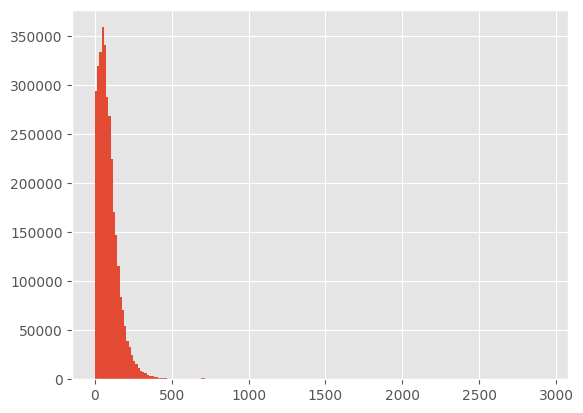

In [45]:
df.sentence.str.len().hist(bins=200);

In [46]:
corpus = df.sentence.values

In [47]:
df

,sentence
0,Побег из Шоушенка Бухгалтер Энди Дюфрейн обвин...
1,Зеленая миля Пол Эджкомб — начальник блока сме...
2,Форрест Гамп От лица главного героя Форреста Г...
3,Список Шиндлера Фильм рассказывает реальную ис...
4,Пострадав в результате несчастного случая бог...
...,...
3260490,Биттеры В ответе слово немецкого происхождения...
3260491,Пиво Международная шкала горечи была придумана...
3260492,АНТ Максим Горький зачет по словам самолет и М...
3260493,Хинин Название ЭТОГО ВЕЩЕСТВА известного также...


In [48]:
df = df.dropna(subset=['sentence'])
df

,sentence
0,Побег из Шоушенка Бухгалтер Энди Дюфрейн обвин...
1,Зеленая миля Пол Эджкомб — начальник блока сме...
2,Форрест Гамп От лица главного героя Форреста Г...
3,Список Шиндлера Фильм рассказывает реальную ис...
4,Пострадав в результате несчастного случая бог...
...,...
3260490,Биттеры В ответе слово немецкого происхождения...
3260491,Пиво Международная шкала горечи была придумана...
3260492,АНТ Максим Горький зачет по словам самолет и М...
3260493,Хинин Название ЭТОГО ВЕЩЕСТВА известного также...


## **Предобработка данных**

In [50]:
def tokenize(text: str) -> List[str]:
    return re.findall("[оаеитнсврмлкдпузябгчьыжхйшцющъoэфєё]+", text.lower())

In [51]:
stopword_set = set(nltk.corpus.stopwords.words("russian"))

In [52]:
lemmatizer = pymorphy2.MorphAnalyzer()

lemmatizer_cache = {}


def lemmatize(token: str) -> str:
    if lemmatizer.word_is_known(token):
        if token not in lemmatizer_cache:
            lemmatizer_cache[token] = lemmatizer.parse(token)[0].normal_form
        return lemmatizer_cache[token]
    return token

In [53]:
def prepare_sentence_dataset(documents: Iterable[str]) -> List[List[str]]:
    # Создаём пустой список для хранения обработанных предложений
    tokenized_sentences = []
    
    # Проходим по каждому документу из входного списка документов
    for document in tqdm_notebook(documents):
        # Разбиваем документ на предложения
        for sentence in nltk.sent_tokenize(document):
            # Токенизируем каждое предложение и лемматизируем токены
            lemmatized_tokens = [lemmatize(token) for token in tokenize(sentence)]
            # Фильтруем лемматизированные токены, удаляя стоп-слова
            filtered_tokens = [token for token in lemmatized_tokens if token not in stopword_set]
            # Добавляем список токенов (предложение) в общий список
            tokenized_sentences.append(filtered_tokens)
    
    # Возвращаем список обработанных предложений
    return tokenized_sentences

In [54]:
sentence_dataset = prepare_sentence_dataset(corpus)

/tmp/ipykernel_9383/1901367261.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for document in tqdm_notebook(documents):


  0%|          | 0/3260495 [00:00<?, ?it/s]

In [55]:
len(sentence_dataset)

3260495

In [56]:
corpus[4]

' Пострадав в\xa0результате несчастного случая богатый аристократ Филипп нанимает в\xa0помощники человека который менее всего подходит для\xa0этой работы\xa0—\xa0молодого жителя предместья Дрисса только что\xa0освободившегося из\xa0тюрьмы Несмотря на\xa0то что\xa0Филипп прикован к\xa0инвалидному креслу Дриссу удается привнести в\xa0размеренную жизнь аристократа дух\xa0приключений'

In [57]:
sentence_dataset[4]

['пострадать',
 'результат',
 'несчастный',
 'случай',
 'богатый',
 'аристократ',
 'филипп',
 'нанимать',
 'помощник',
 'человек',
 'который',
 'менее',
 'весь',
 'подходить',
 'работа',
 'молодой',
 'житель',
 'предместье',
 'дрисса',
 'освободиться',
 'тюрьма',
 'несмотря',
 'филипп',
 'приковать',
 'инвалидный',
 'кресло',
 'дриссу',
 'удаваться',
 'привнести',
 'размеренный',
 'жизнь',
 'аристократ',
 'дух',
 'приключение']

In [59]:
sentences = [' '.join(words) for words in sentence_dataset]

In [60]:
sentences

['побег шоушенка бухгалтер энди дюфрейн обвинить убийство собственный жена её любовник оказаться тюрьма название шоушенк сталкиваться жестокость беззаконие царить оба сторона решётка каждый попадать стена становиться раб конец жизнь энди обладать живой ум добрый душа находить подход заключить охранник добиваться особый расположение',
 'зелёный миля пол эджкомб начальник блок смертник тюрьма холодный гора каждый узник который однажды проходить зелёный миля путь место казнь пол повидать заключить надзиратель время работа однако гигант джон коффи обвинить страшный преступление стать самый необычный обитатель блок',
 'форрест гамп лицо главное герой форреста гампа слабоумный безобидный человек благородный открытый сердце рассказываться история необыкновенный жизнифантастическим образ превращаться известный футболист герой война преуспевать бизнесмен становиться миллиардер оставаться бесхитростный глупый добрый форреста ждать постоянный успех весь любить девочка который дружить детство взаи

In [65]:
# Имя файла для записи
filename = "sentences_1.txt"

# Запись предложений в файл
with open(filename, "w", encoding="utf-8") as file:
    for sentence in sentences:
        file.write(sentence + "\n")

## **FastText обучение**

### ***Запускаем одну из предобученных моделей fasttext для русского языка из интернета***

In [9]:
import fasttext

# Путь к предобученной модели
pretrained_model_path = "marus_data/cc.ru.300.bin"

# Загрузка предобученной модели
pretrained_model_base = fasttext.load_model(pretrained_model_path)

In [5]:
from numpy.linalg import norm

In [11]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "Полина Гагарина"
word2 = "Гагарина"

# Get word vectors
vec1 = pretrained_model_base.get_word_vector(word1)
vec2 = pretrained_model_base.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'Полина Гагарина' and 'Гагарина': 0.4571617841720581


**Обучаю модель на 5 эпохах на подготовленных данных из файла sentences_1.txt и сохраняяю как новую модель**

In [6]:
pretrained_model = fasttext.train_unsupervised(
    input='sentences_1.txt',
    epoch=5       # Количество эпох
)

# Сохранение обновленной модели
pretrained_model.save_model("updated_model_2.bin")

Read 32M words
Number of words:  80481
Number of labels: 0
Progress: 100.0% words/sec/thread:   26640 lr:  0.000000 avg.loss:  1.257928 ETA:   0h 0m 0s


**Обучаю модель на 10 эпохах на подготовленных данных из файла sentences_1.txt и сохраняяю как новую модель**

In [ ]:
pretrained_model = fasttext.train_unsupervised(
    input='sentences_1.txt',
    epoch=10       # Количество эпох
)

# Сохранение обновленной модели
pretrained_model.save_model("updated_model_3.bin")

Read 32M words
Number of words:  80481
Number of labels: 0
Progress:  15.1% words/sec/thread:   23077 lr:  0.042440 avg.loss:  2.118923 ETA:   0h28m14s  6.8% words/sec/thread:   20348 lr:  0.046609 avg.loss:  2.131502 ETA:   0h35m10s

**Обучаю модели на 1 и 4 эпохах соответсвенно на подготовленных данных из файла sentences_10.txt и сохраняяю как новую модель**

**Данные молеи нужны для распознавания похожести единичного и множественноготчисла для тем. Позже вместо этого бала добавленна лемматизация на бэке.**

In [3]:
pretrained_model = fasttext.train_unsupervised(
    input='sentences_10.txt',
    epoch=4       # Количество эпох
)

# Сохранение обновленной модели
pretrained_model.save_model("updated_model_100.bin")

Read 32M words
Number of words:  81788
Number of labels: 0
Progress: 100.0% words/sec/thread:   26104 lr:  0.000000 avg.loss:  1.445245 ETA:   0h 0m 0s 66.6% words/sec/thread:   26808 lr:  0.016706 avg.loss:  1.986553 ETA:   0h 3m52s


In [24]:
pretrained_model_old = fasttext.train_unsupervised(
    input='sentences_10.txt',
    epoch=1      # Количество эпох
)

# Сохранение обновленной модели
pretrained_model_old.save_model("updated_model_1000.bin")

Read 32M words
Number of words:  81788
Number of labels: 0
Progress: 100.0% words/sec/thread:   27534 lr:  0.000000 avg.loss:  2.158482 ETA:   0h 0m 0s


In [57]:
pretrained_model = fasttext.load_model("updated_model_1000.bin")

In [58]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "ящик"
word2 = "ящики"

# Get word vectors
vec1 = pretrained_model.get_word_vector(word1)
vec2 = pretrained_model.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'ящик' and 'ящики': 0.8162327408790588


In [59]:
import fasttext

# Путь к предобученной модели
pretrained_model_path = "updated_model_3.bin"

# Загрузка предобученной модели
pretrained_model_init = fasttext.load_model(pretrained_model_path)

In [3]:
import fasttext

# Путь к предобученной модели
pretrained_model_path = "updated_model_1000.bin"

# Загрузка предобученной модели
pretrained_model_old = fasttext.load_model(pretrained_model_path)

In [6]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "алла пугачёва"
word2 = "пугачёва"

# Get word vectors
vec1 = pretrained_model_old.get_word_vector(word1)
vec2 = pretrained_model_old.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'алла пугачёва' and 'пугачёва': 0.9324679970741272


In [7]:
import fasttext

# Путь к предобученной модели
pretrained_model_path = "updated_model_3.bin"

# Загрузка предобученной модели
pretrained_model_init = fasttext.load_model(pretrained_model_path)

In [8]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "алла пугачёва"
word2 = "пугачёва"

# Get word vectors
vec1 = pretrained_model_init.get_word_vector(word1)
vec2 = pretrained_model_init.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'алла пугачёва' and 'пугачёва': 0.939157247543335


In [12]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "Полина Гагарина"
word2 = "Гагарина"

# Get word vectors
vec1 = pretrained_model_init.get_word_vector(word1)
vec2 = pretrained_model_init.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'Полина Гагарина' and 'Гагарина': 0.9185465574264526


#### ***Добавлю к общим данным для обучения данные для модели множественное-единственное число. Файл sentences_10.txt такой же как и sentences_1.txt***

In [4]:
# Открываем файл singular_and_plural.txt для чтения и считываем все слова в список
with open('marus_data/singular_and_plural.txt', 'r', encoding='utf-8') as f:
    additional_words = f.readlines()

# Открываем файл sentences_1.txt для дописывания и добавляем данные из try_1.txt в конец
with open('sentences_10.txt', 'a', encoding='utf-8') as f:
    f.write('\n')  # Переходим на новую строку
    f.write('\n'.join(additional_words))  # Записываем слова из try_1.txt


In [2]:
# Открываем файл для чтения
with open('sentences_10.txt', 'r', encoding='utf-8') as file:
    # Считываем все строки из файла
    lines = file.readlines()

# Выводим последние 30 строк
for line in lines[-30:]:
    print(line.strip())



ящерицы

ящерка

ящерки

ящерогад

ящерогады

ящик

ящики

ящичек

ящички

ящичник

ящичники

ящур

ящуры

ящурка

ящурки


#### ****Примеры восприятия моделью фраз с опечатками****

In [3]:
import fasttext

# Путь к предобученной модели
pretrained_model_path = "updated_model_3.bin"

# Загрузка предобученной модели
pretrained_model = fasttext.load_model(pretrained_model_path)

In [5]:
from numpy.linalg import norm

In [16]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "я свободен"
word2 = "я свободен"

# Get word vectors
vec1 = pretrained_model.get_word_vector(word1)
vec2 = pretrained_model.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'я свободен' and 'я свабоден': 0.7028183937072754


In [56]:
pretrained_model.save_model("updated_model_33.vec")

****Ещё примеры близких понятий****

In [16]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "отец"
word2 = "папа"

# Get word vectors
vec1 = pretrained_model_init.get_word_vector(word1)
vec2 = pretrained_model_init.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'отец' and 'папа': 0.7734448909759521


In [15]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "Алла Пугачёва"
word2 = "Пугачёва"

# Get word vectors
vec1 = pretrained_model_init.get_word_vector(word1)
vec2 = pretrained_model_init.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'Алла Пугачёва' and 'Пугачёва': 0.9754924178123474


### ***Загрузка подели моей предобученной на хард  негативах***

In [19]:
# Путь к предобученной модели
pretrained_model_path = "updated_model_45.bin"

# Загрузка предобученной модели
model_45 = fasttext.load_model(pretrained_model_path)

In [20]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "мама"
word2 = "папа"

# Get word vectors
vec1 = model_45.get_word_vector(word1)
vec2 = model_45.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'мама' and 'папа': -0.13466446101665497


In [21]:
# Words to compare
word1 = "мама"
word2 = "мамочка"

# Get word vectors
vec1 = model_45.get_word_vector(word1)
vec2 = model_45.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'мама' and 'мамочка': 0.8408859968185425


### ****Попытки обучения модели на хард негативах для развода разных понятий, которые могут употребляться в схожем контексте, но иметь разные значения. Например, мама и папа****

In [139]:
with open('new_data.txt', 'w') as f:
    f.write('__label__different мама папа\n')
    f.write('__label__different мама папуля\n')
    f.write('__label__different мама отец\n')
    f.write('__label__same мама мама\n')
    f.write('__label__same мама мамочка\n')
    f.write('__label__same мама мать\n')



In [93]:
import fasttext
import numpy as np

# Открытие файла для записи новых данных
with open('new_data.txt', 'w') as f:
    f.write('__label__different мама папа\n')
    f.write('__label__different мама папуля\n')
    f.write('__label__different мама отец\n')

# Загрузка предобученной модели и извлечение векторов слов
pretrained_model = fasttext.load_model('updated_model_3.bin')
words = pretrained_model.get_words()
word_vectors = np.array([pretrained_model.get_word_vector(word) for word in words])

# Сохранение векторов слов в файл
pretrained_vectors_file = 'pretrained_vectors.vec'
with open(pretrained_vectors_file, 'w', encoding='utf-8') as f:
    f.write(f"{len(words)} {len(word_vectors[0])}\n")
    for word, vector in zip(words, word_vectors):
        vector_str = ' '.join(map(str, vector))
        f.write(f"{word} {vector_str}\n")

# Обучение модели на новых данных, используя предобученные векторы слов
model = fasttext.train_supervised(input='new_data.txt', pretrainedVectors=pretrained_vectors_file, neg=5)

# Оценка косинусной близости между "мамой" и "папой"
cosine_similarity = np.dot(model.get_word_vector('мама'), model.get_word_vector('папа')) / (np.linalg.norm(model.get_word_vector('мама')) * np.linalg.norm(model.get_word_vector('папа')))
print("Косинусная близость между 'мамой' и 'папой' до дообучения:", cosine_similarity)

# Найдем трудные негативные примеры, где "мама" и "папа" неправильно классифицированы
hard_negatives = []
with open('new_data.txt', 'r') as f:
    for line in f:
        label, text = line.strip().split(' ', 1)
        prediction = model.predict(text)[0][0]
        if prediction != label:
            hard_negatives.append(text)

# Дообучение модели на трудных негативных примерах
for text in hard_negatives:
    model = fasttext.train_supervised(input=text, model=model)

# Оценка косинусной близости между "мамой" и "папой" после дообучения
cosine_similarity_after = np.dot(model.get_word_vector('мама'), model.get_word_vector('папа')) / (np.linalg.norm(model.get_word_vector('мама')) * np.linalg.norm(model.get_word_vector('папа')))
print("Косинусная близость между 'мамой' и 'папой' после дообучения:", cosine_similarity_after)


Read 0M words
Number of words:  5
Number of labels: 1


Косинусная близость между 'мамой' и 'папой' до дообучения: 0.8196124
Косинусная близость между 'мамой' и 'папой' после дообучения: 0.8196124


Progress: 100.0% words/sec/thread:  568793 lr:  0.000000 avg.loss:  0.000000 ETA:   0h 0m 0s


In [46]:
# Дообучение модели на новых данных с использованием хард негативов
pretrained_model = fasttext.train_supervised(
    input='new_data.txt',  # Предобученные векторы слов
    neg=5  # Количество хард негативов
)

Read 0M words
Number of words:  28
Number of labels: 1
Progress: 100.0% words/sec/thread:  166967 lr:  0.000000 avg.loss:  0.000000 ETA:   0h 0m 0s


In [54]:
pretrained_model.get_dimension()

100

In [140]:
words = pretrained_model.get_words()
word_vectors = np.array([pretrained_model.get_word_vector(word) for word in words])

# Save the word vectors to a file
pretrained_vectors_file = 'pretrained_vectors.vec'
with open(pretrained_vectors_file, 'w', encoding='utf-8') as f:
    f.write(f"{len(words)} {len(word_vectors[0])}\n")
    for word, vector in zip(words, word_vectors):
        vector_str = ' '.join(map(str, vector))
        f.write(f"{word} {vector_str}\n")

# Train the model on new data using the pre-trained word vectors
model = fasttext.train_supervised(input='new_data.txt', pretrainedVectors=pretrained_vectors_file, neg=3, epoch=10 )

Read 0M words
Number of words:  7
Number of labels: 2
Progress: 100.0% words/sec/thread:  571690 lr:  0.000000 avg.loss:  0.002863 ETA:   0h 0m 0s


In [129]:
with open('positive_negative_data.txt', 'w') as f:
    f.write('__label__positive мама\n')
    f.write('__label__positive мама\n')
    f.write('__label__positive мама\n')
    f.write('__label__positive мамочка\n')
    f.write('__label__negative мама\n')
    f.write('__label__negative папа\n')
    f.write('__label__negative мама\n')
    f.write('__label__negative отец\n')
    
words = pretrained_model.get_words()
word_vectors = np.array([pretrained_model.get_word_vector(word) for word in words])

# Save the word vectors to a file
pretrained_vectors_file = 'pretrained_vectors.vec'
with open(pretrained_vectors_file, 'w', encoding='utf-8') as f:
    f.write(f"{len(words)} {len(word_vectors[0])}\n")
    for word, vector in zip(words, word_vectors):
        vector_str = ' '.join(map(str, vector))
        f.write(f"{word} {vector_str}\n")


#### *****Итоговая модель*****

In [130]:
# Дообучение модели на файлах данных
model = fasttext.train_supervised(input='positive_negative_data.txt', pretrainedVectors=pretrained_vectors_file, epoch=1, wordNgrams=10, verbose=2)

Read 0M words
Number of words:  5
Number of labels: 2
Progress: 100.0% words/sec/thread:  113647 lr:  0.000000 avg.loss:  0.437803 ETA:   0h 0m 0s


In [153]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

# Words to compare
word1 = "снег"
word2 = "снеговик"

# Get word vectors
vec1 = model.get_word_vector(word1)
vec2 = model.get_word_vector(word2)

# Calculate cosine similarity
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'снег' and 'снеговик': 0.5306922197341919


In [160]:
import numpy as np

def cosine_similarity(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # или любое другое значение по вашему усмотрению
    return np.dot(vec1, vec2) / (norm1 * norm2)

# Загрузка предобученной модели

# Получение слов и их векторов из модели
words = pretrained_model.get_words()
word_vectors = np.array([pretrained_model.get_word_vector(word) for word in words])

# Выбор слов для сравнения
word1 = "белый снег"
word2 = "снег"

# Получение векторов для выбранных слов
vec1 = pretrained_model.get_word_vector(word1)
vec2 = pretrained_model.get_word_vector(word2)

# Вычисление косинусного сходства с обработкой возможного деления на ноль
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")


Similarity between 'белый снег' and 'снег': 0.6797948479652405


In [180]:
import numpy as np

def cosine_similarity(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # или любое другое значение по вашему усмотрению
    return np.dot(vec1, vec2) / (norm1 * norm2)

# Загрузка предобученной модели

# Получение слов и их векторов из модели
words = model.get_words()
word_vectors = np.array([model.get_word_vector(word) for word in words])

# Выбор слов для сравнения
word1 = "папа"
word2 = "папка"

# Получение векторов для выбранных слов
vec1 = model.get_word_vector(word1)
vec2 = model.get_word_vector(word2)

# Вычисление косинусного сходства с обработкой возможного деления на ноль
similarity = cosine_similarity(vec1, vec2)

print(f"Similarity between '{word1}' and '{word2}': {similarity}")


Similarity between 'папа' and 'папка': 0.26901885867118835


### ****Пример итоговой работы****

In [178]:
def cosine_similarity(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0 
    return np.dot(vec1, vec2) / (norm1 * norm2)


words_to_compare = ["мама", "мамочка", "мать", "папа", "отец", "папочка"]

for word1 in words_to_compare:
    for word2 in words_to_compare:
        if word1 != word2: 
            vec1 = model.get_word_vector(word1)
            vec2 = model.get_word_vector(word2)
            similarity = cosine_similarity(vec1, vec2)
            print(f"Similarity between '{word1}' and '{word2}': {similarity}")

Similarity between 'мама' and 'мамочка': 0.8408859968185425
Similarity between 'мама' and 'мать': 0.875531792640686
Similarity between 'мама' and 'папа': -0.13466446101665497
Similarity between 'мама' and 'отец': -0.2309647649526596
Similarity between 'мама' and 'папочка': 0.39189469814300537
Similarity between 'мамочка' and 'мама': 0.8408859968185425
Similarity between 'мамочка' and 'мать': 0.7875926494598389
Similarity between 'мамочка' and 'папа': -0.19743692874908447
Similarity between 'мамочка' and 'отец': -0.2947370111942291
Similarity between 'мамочка' and 'папочка': 0.4873543679714203
Similarity between 'мать' and 'мама': 0.875531792640686
Similarity between 'мать' and 'мамочка': 0.7875926494598389
Similarity between 'мать' and 'папа': -0.22707371413707733
Similarity between 'мать' and 'отец': -0.18873591721057892
Similarity between 'мать' and 'папочка': 0.34844282269477844
Similarity between 'папа' and 'мама': -0.13466446101665497
Similarity between 'папа' and 'мамочка': -0.19

In [163]:
model.save_model("updated_model_45.bin")

**Оценивание моделей**

In [23]:
EVAL_PATH = "marus_data/ru_simlex965.tsv"

In [24]:
eval_set = pd.read_csv(EVAL_PATH, sep="\t")

eval_set.columns = ["word1", "word2", "human_score"]

****Базовая предобученная модель****

In [51]:
# Список для хранения оценок модели
model_scores = []

# Проход по всем строкам DataFrame и вычисление оценки модели для каждой пары слов
for index, row in eval_set.iterrows():
    word1 = row["word1"]
    word2 = row["word2"]
    
    # Получение векторов слов из модели FastText
    vec1 = pretrained_model_base.get_word_vector(word1)
    vec2 = pretrained_model_base.get_word_vector(word2)
    
    # Вычисление косинусного сходства между векторами слов
    similarity = cosine_similarity(vec1, vec2)
    
    # Добавление оценки модели в список
    model_scores.append(similarity)

# Добавление колонки model_score к DataFrame
eval_set["model_score"] = model_scores

# Отображение результата
print(eval_set)

          word1       word2  human_score  model_score
0        авария    бедствие         6.15     0.345598
1        август       месяц         2.85     0.489450
2       авиация       полет         6.77     0.274829
3    автомобиль       гудок         1.85     0.321791
4    автомобиль  автострада         1.23     0.268069
..          ...         ...          ...          ...
960      яблоко      солнце         0.15     0.388264
961        ядро       пушка         2.77     0.181379
962        язык       горло         1.38     0.271724
963         ярд        дюйм         2.62     0.383099
964    яростный        злой         7.46     0.509149

[965 rows x 4 columns]


In [52]:
eval_set.sort_values("human_score").tail(50).style.background_gradient(
    subset=["model_score"]
)

,word1,word2,human_score,model_score
279,изобилие,множество,8.690000,0.523323
287,исследовать,изучать,8.690000,0.754795
180,дискуссия,спор,8.690000,0.466342
732,руководство,управление,8.690000,0.592891
427,музыка,мелодия,8.770000,0.705389
26,аргументировать,обосновывать,8.770000,0.820602
129,гонорар,зарплата,8.770000,0.366312
500,общение,беседа,8.850000,0.504679
239,задание,задача,8.850000,0.409341
260,злость,ярость,8.850000,0.692562


In [53]:
pearsonr(eval_set["model_score"], eval_set["human_score"])

PearsonRResult(statistic=0.3570108075141912, pvalue=2.2041204678895935e-30)

### ****Коэффициент корреляции Пирсона измеряет степень линейной зависимости между двумя переменными. Значение 0.357 указывает на умеренную положительную линейную зависимость между оценками модели и оценками человека. Это означает, что по мере увеличения одной оценки, другая также имеет тенденцию к увеличению, но связь не является очень сильной.****

### ****P-значение (p-value) показывает вероятность того, что наблюдаемая корреляция произошла случайно. Очень малое p-значение (в данном случае 2.2041204678895935e-30) указывает на то, что вероятность случайного появления такой корреляции чрезвычайно мала. Обычно, если p-значение меньше 0.05, результат считается статистически значимым. Здесь p-значение настолько мало, что говорит о высокой статистической значимости корреляции, несмотря на умеренную величину самого коэффициента корреляции.****

In [54]:
spearmanr(eval_set["model_score"], eval_set["human_score"])

SignificanceResult(statistic=0.3067157317637105, pvalue=1.8158045734533696e-22)

***Здесь значение около 0.307 указывает на умеренную корреляцию между переменными.***

***В данном случае, очень маленькое значение p-value (порядка e-22) указывает на высокую статистическую значимость корреляции.***

In [25]:
# Список для хранения оценок модели
model_scores = []

# Проход по всем строкам DataFrame и вычисление оценки модели для каждой пары слов
for index, row in eval_set.iterrows():
    word1 = row["word1"]
    word2 = row["word2"]
    
    # Получение векторов слов из модели FastText
    vec1 = pretrained_model_init.get_word_vector(word1)
    vec2 = pretrained_model_init.get_word_vector(word2)
    
    # Вычисление косинусного сходства между векторами слов
    similarity = cosine_similarity(vec1, vec2)
    
    # Добавление оценки модели в список
    model_scores.append(similarity)

# Добавление колонки model_score к DataFrame
eval_set["model_score"] = model_scores

# Отображение результата
print(eval_set)

          word1       word2  human_score  model_score
0        авария    бедствие         6.15     0.471576
1        август       месяц         2.85     0.507441
2       авиация       полет         6.77     0.309940
3    автомобиль       гудок         1.85     0.513708
4    автомобиль  автострада         1.23     0.742374
..          ...         ...          ...          ...
960      яблоко      солнце         0.15     0.398695
961        ядро       пушка         2.77     0.333919
962        язык       горло         1.38     0.137736
963         ярд        дюйм         2.62     0.472101
964    яростный        злой         7.46     0.353912

[965 rows x 4 columns]


In [26]:
eval_set.sort_values("human_score").tail(50).style.background_gradient(
    subset=["model_score"]
)

,word1,word2,human_score,model_score
279,изобилие,множество,8.690000,0.464504
287,исследовать,изучать,8.690000,0.699139
180,дискуссия,спор,8.690000,0.775976
732,руководство,управление,8.690000,0.523282
427,музыка,мелодия,8.770000,0.829538
26,аргументировать,обосновывать,8.770000,0.638377
129,гонорар,зарплата,8.770000,0.657139
500,общение,беседа,8.850000,0.658946
239,задание,задача,8.850000,0.564669
260,злость,ярость,8.850000,0.715575


In [27]:
pearsonr(eval_set["model_score"], eval_set["human_score"])

PearsonRResult(statistic=0.35438823134363173, pvalue=6.20927085176577e-30)

***Коэффициент корреляции Пирсона измеряет степень линейной зависимости между двумя переменными.
Значение 0.354 указывает на умеренную положительную линейную зависимость между оценками модели и оценками человека. Это означает, что по мере увеличения одной оценки, другая также имеет тенденцию к увеличению, но связь не является очень сильной.***

***P-значение (p-value) показывает вероятность того, что наблюдаемая корреляция произошла случайно.
Очень малое p-значение (в данном случае 6.20927085176577e-30) указывает на то, что вероятность случайного появления такой корреляции чрезвычайно мала. Обычно, если p-значение меньше 0.05, результат считается статистически значимым.
Здесь p-значение настолько мало, что говорит о высокой статистической значимости корреляции, несмотря на умеренную величину самого коэффициента корреляции.***

In [28]:
spearmanr(eval_set["model_score"], eval_set["human_score"])

SignificanceResult(statistic=0.334356145328677, pvalue=1.2349237036798493e-26)

### ***Коэффициент корреляции Спирмена измеряет степень монотонной зависимости между двумя переменными. Значение 0.334 указывает на умеренную положительную монотонную зависимость между оценками модели и оценками человека. Это означает, что по мере увеличения одной оценки, другая также имеет тенденцию к увеличению, но связь не является очень сильной.***

### ***P-значение (p-value) показывает вероятность того, что наблюдаемая корреляция произошла случайно. Очень малое p-значение (в данном случае 1.2349237036798493e-26) указывает на то, что вероятность случайного появления такой корреляции чрезвычайно мала. Обычно, если p-значение меньше 0.05, результат считается статистически значимым. Здесь p-значение настолько мало, что говорит о высокой статистической значимости корреляции, несмотря на умеренную величину самого коэффициента корреляции.***

## **Модель init  показывает результаты получше базоваой модели на этих оценочных данных. А на примерах для "Своя игра", которые  были выше показывает результат значительно лучше, чем базовая модель.**

#### Пример кода для обработки предложения с поиском в нём слова или фразы близкого к заданному

In [38]:
def print_ngrams(sentence, correct_answer):
    # Разбиваем предложение на слова
    words = sentence.split()

    # Проходим по предложению и выводим n-граммы для различных значений n
    for n in range(1, len(words) + 1):
        print(f"{n}-граммы:")
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i + n])
            print(ngram)
            vec_out = pretrained_model_base.get_word_vector(correct_answer)
            vec_in = pretrained_model_base.get_word_vector(ngram)
            sim_res = cosine_similarity(vec_in, vec_out)
            print(f'{sim_res=}')
            if sim_res >= 0.42:
                print('Успех!')
                return True
        print()


In [39]:
# Пример предложения
sentence = "Это пример предложения для демонстрации вывода n-грамм."

# Вызываем функцию для вывода n-грамм
print_ngrams(sentence, 'предложение')

1-граммы:
Это
sim_res=0.26446185
пример
sim_res=0.14929084
предложения
sim_res=0.6426995
Успех!


True

In [42]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def print_ngrams(sentence, correct_answer):
    # Разбиваем предложение на слова
    words = sentence.split()

    # Проходим по предложению и выводим n-граммы для различных значений n
    for n in range(1, len(words) + 1):
        print(f"{n}-граммы:")
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i + n])
            print(ngram)

            # Получим вектора по словам (n-граммам)
            vec1 = pretrained_model_base.get_word_vector(correct_answer)
            vec2 = pretrained_model_base.get_word_vector(ngram)

            # Вычисляем косинусную близость
            sim_res = cosine_similarity(vec1, vec2)
            print(f'{sim_res=}')
            if sim_res >= 0.42:
                print('Успех!')
                return True
        print()


In [32]:
# Пример предложения
sentence = "Это пример предложения для демонстрации вывода n-грамм."

# Вызываем функцию для вывода n-грамм
print_ngrams(sentence, 'предложение')

1-граммы:
Это
sim_res=0.26446185
пример
sim_res=0.14929084
предложения
sim_res=0.6426995
Успех!


True